# 이상값 탐색 및 처리 실습

## 1. 필요 라이브러리 import

In [1]:
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# os에 따른 Font 깨짐 제거를 위해 Font 지정
import os
if os.name == 'nt' :
    font_family = "Malgun Gothic"
    
# 값이 깨지는 문제 해결을 위해 파라미터값 설정
sns.set(font = font_family, rc = {"axes.unicode_minus" : False})

## 2. Z검정(Z-Test)을 이용한 이상값 처리

### 1) 데이터 생성

In [3]:
# 3000개의 랜덤 데이터 생성
np_data = np.random.randint(1, 100, size = 3000)
data = list(np_data)

In [4]:
data[0:2]

[25, 69]

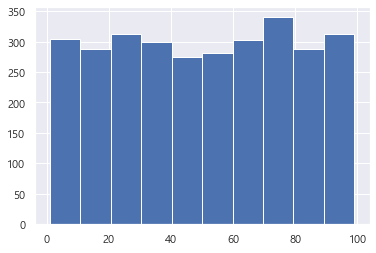

In [5]:
# 히스토그램으로 생성된 데이터 분포 확인
plt.hist(data)
plt.show()

In [6]:
# data의 정규분포 확인
data_mean = np.mean(data)
data_std = np.std(data)

print(data_mean)
print(data_std)

50.27433333333333
28.613232507977067


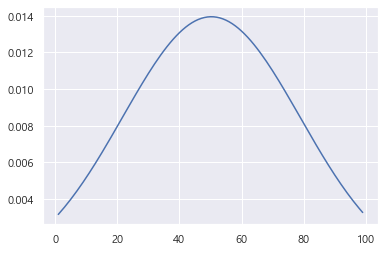

In [7]:
# 확률 밀도 함수 생성
pdf = stats.norm.pdf(np.sort(data), data_mean, data_std)
plt.figure()
plt.plot(np.sort(data), pdf)

8.526512829121202e-17
1.0


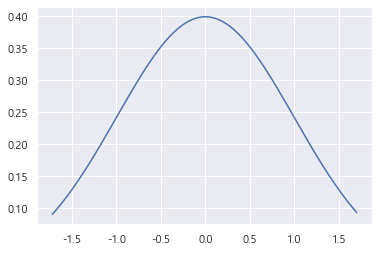

In [8]:
# 표준정규분포(z분포)로 변환
std_list = []

for i in data:
    z = (i - data_mean) / data_std
    std_list.append(z)
    
ol_data_mean = np.mean(std_list)
ol_data_std = np.std(std_list)

print(ol_data_mean)
print(ol_data_std)

ol_pdf = stats.norm.pdf(np.sort(std_list),
                       ol_data_mean, ol_data_std)
plt.figure()
plt.plot(np.sort(std_list), ol_pdf)

### 2) 데이터셋에 이상값 추가

50.467441860465115
29.002733914564764


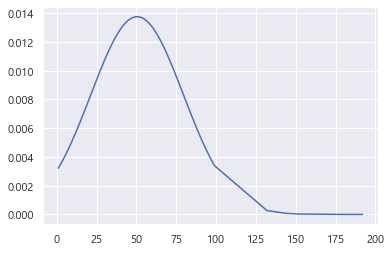

In [9]:
# 이상값 추가
ol_data = data.copy()
ol_no = 10

for i in range(ol_no):
    rand_no = random.randint(0, len(data))
    ol_data.insert(rand_no, ol_data[rand_no] * 2)
    
# 이상값이 추가된 데이터의 정규분포도
ol_data_mean = np.mean(ol_data)
ol_data_std = np.std(ol_data)

print(ol_data_mean)
print(ol_data_std)

ol_pdf = stats.norm.pdf(np.sort(ol_data),
                       ol_data_mean, ol_data_std)

plt.figure()
plt.plot(np.sort(ol_data), ol_pdf)

3.776971352877609e-17
0.9999999999999998


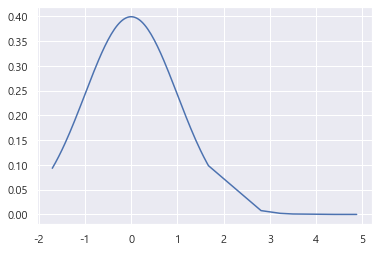

In [10]:
# 이상값 추가된 데이터의 표준화
ol_std_list = []

for i in ol_data:
    z = (i - ol_data_mean) / ol_data_std
    ol_std_list.append(z)
    
ol_st_data_mean = np.mean(ol_std_list)
ol_st_data_std = np.std(ol_std_list)

print(ol_st_data_mean)
print(ol_st_data_std)

ol_std_pdf = stats.norm.pdf(np.sort(ol_std_list),
                           ol_st_data_mean, ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std_pdf)

### 3) Z값의 2가 넘어가는 데이터 삭제

In [11]:
# 전체 라인수 확인
len(ol_std_list)

3010

In [12]:
# -2 ~ 2 범위 벗어나면 이상값으로 제거
for i in ol_std_list:
    z = i
    if z > 2:
        ol_std_list.remove(z)
    if z < - 2:
        ol_std_list.remove(z)

In [13]:
# 이상값 제거 후 라인수
len(ol_std_list)

3004

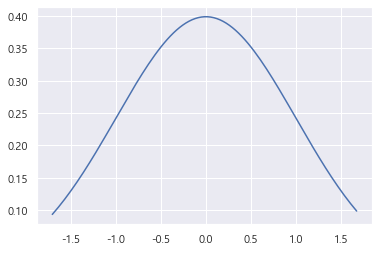

In [14]:
# 이상값 제거 후 표준정규분포 확인
ol_std_pdf = stats.norm.pdf(np.sort(ol_std_list), ol_st_data_mean, ol_st_data_std)

plt.figure()
plt.plot(np.sort(ol_std_list), ol_std_pdf)

## 3. 사분위수 범위로 이상값 삭제

### 1) 이상값 데이터 생성

In [15]:
# 이상값 데이터 생성
boxdata = pd.DataFrame(np.random.randn(100, 3), columns = ['A열', 'B열', 'C열'])
boxdata.head()

,A열,B열,C열
0,-1.435894,0.442744,1.323289
1,-1.161672,-0.097006,-0.331294
2,-2.139262,-0.939664,-0.029483
3,1.116480,0.891106,0.355717
4,0.676216,0.190343,0.430361


### 2) 이상값 데이터 확인 

In [16]:
# 기술 통계 정보로 percentile 확인
boxdata.describe()

,A열,B열,C열
count,100.000000,100.000000,100.000000
mean,-0.050793,-0.090802,0.044924
std,1.078847,1.038165,1.048403
min,-3.019297,-2.494144,-2.363556
25%,-0.740532,-0.748967,-0.599552
50%,-0.044522,-0.112457,0.092663
75%,0.727668,0.445218,0.727276
max,2.250696,3.521452,3.511754


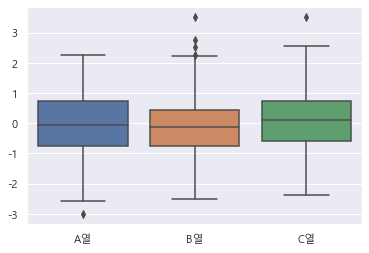

In [17]:
# boxplot을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

In [18]:
# 이상값 계산하는 함수
def get_outlier(df = None, column = None, weight = 1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_idx

# 함수 사용해서 이상값 확인
outlier_idx = get_outlier(df = boxdata, column = 'B열', weight = 1.5)
outlier_idx

Int64Index([16, 17, 24, 80], dtype='int64')

In [19]:
# 이상값 삭제
boxdata.drop(outlier_idx, axis = 0, inplace = True)
boxdata.shape

(96, 3)

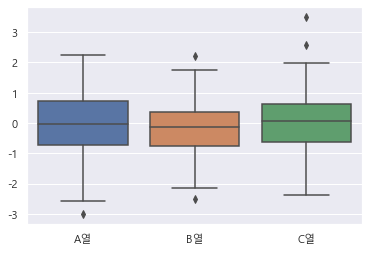

In [20]:
# boxplot을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()

In [21]:
# 함수 이용해서 이상값 확인
outlier_idx = get_outlier(df = boxdata, column = 'A열', weight = 1.5)
outlier_idx

Int64Index([18], dtype='int64')

In [22]:
# 이상값 삭제
boxdata.drop(outlier_idx, axis = 0, inplace = True)
boxdata.shape

(95, 3)

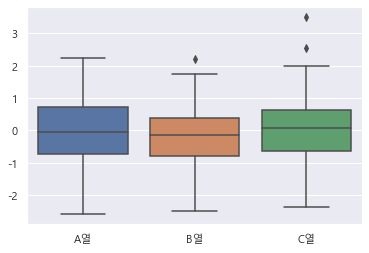

In [23]:
# boxplot을 이용한 이상값 확인
sns.boxplot(data = boxdata)
plt.show()